<a href="https://colab.research.google.com/github/samiha-mahin/WaterQuality/blob/main/WQ_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5331 - loss: 0.6989 - val_accuracy: 0.6438 - val_loss: 0.6564
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5900 - loss: 0.6632 - val_accuracy: 0.6166 - val_loss: 0.6434
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6048 - loss: 0.6487 - val_accuracy: 0.6070 - val_loss: 0.6455
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6367 - loss: 0.6241 - val_accuracy: 0.6182 - val_loss: 0.6328
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6375 - loss: 0.6260 - val_accuracy: 0.6406 - val_loss: 0.6209
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6497 - loss: 0.6120 - val_accuracy: 0.6470 - val_loss: 0.6181
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6440 - loss: 0.6020 - val_accuracy: 0.6166 - val_loss: 0.6505
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6696 - loss: 0.6029 - val_accuracy: 0.6326 - val_loss

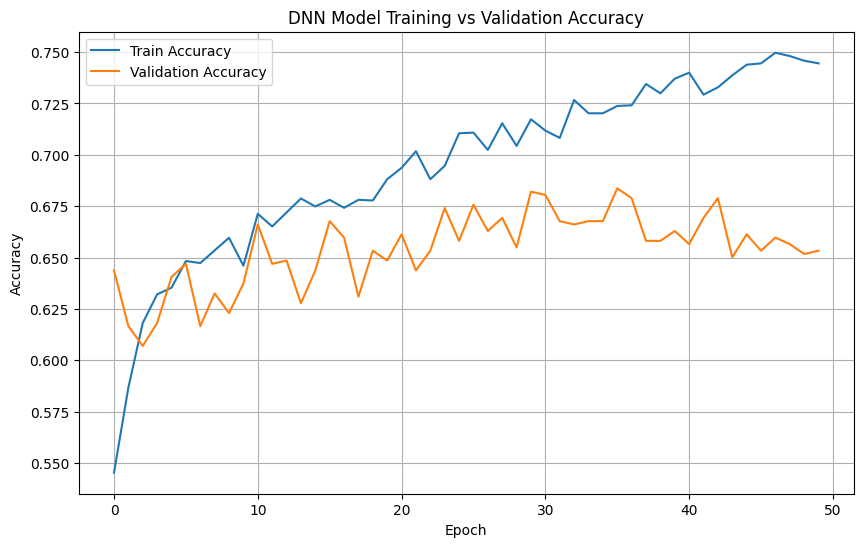

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Load and engineer features
df = pd.read_csv("cleaned_data.csv")

# Handle missing values
df = df.fillna(df.mean())  # Replace missing values with column mean

# Feature engineering (creating new features based on the dataset)
df["Solids_per_Hardness"] = df["Solids"] / (df["Hardness"] + 1e-5)
df["pH_Turbidity"] = df["ph"] * df["Turbidity"]
df["Sulfate_Chloramines"] = df["Sulfate"] * df["Chloramines"]

# Step 2: Features and labels
X = df.drop("Potability", axis=1)
y = df["Potability"]

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 4: Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 6: Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_pca, y_train)

# Step 7: Build DNN Model (Deep Neural Network)
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Train the model
history_dnn = dnn_model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, validation_data=(X_test_pca, y_test), verbose=1)

# Step 9: Evaluate the model
y_pred_dnn = (dnn_model.predict(X_test_pca) > 0.5).astype("int32")
acc_dnn = accuracy_score(y_test, y_pred_dnn)

# Display results
print(f"DNN Accuracy: {acc_dnn}")
print("📊 Classification Report (DNN):\n", classification_report(y_test, y_pred_dnn))

# Step 10: Plot accuracy for the DNN model
plt.figure(figsize=(10, 6))
plt.plot(history_dnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('DNN Model Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
